In [1]:
#Data handling
from mudata import MuData
import numpy as np
from anndata import AnnData
import scanpy
import pandas as pd
from sklearn.neighbors import kneighbors_graph
import networkx as nx

#Embedding
from node2vec import Node2Vec
from sklearn.manifold import TSNE

#Modelling
from sklearn.mixture import GaussianMixture

#OT
import ot
from gmmot import *

#Plot
from pymnet import *
import seaborn as sns
import matplotlib.pyplot as plt

#GRAPE
import grape
from grape import Graph
from grape.embedders import Node2VecGloVeEnsmallen

rng = np.random.default_rng(seed=42)
%matplotlib inline

/home/kuehn/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Loading from Multigraph Edgelist
path = "RZ_R9_multinex.edgelist"
G = nx.read_edgelist(path) #can't store node properties
G = nx.read_gexf(path.split('.', 1)[0]+'.gexf') #can store node properties

nx.get_node_attributes(G, 'layer')

{'0': 'l2',
 'intermediate_CM': 'l1',
 'Capillary_Endo': 'l1',
 'damaged_CM': 'l1',
 'vCM_3': 'l1',
 'healthy_CM': 'l1',
 '1': 'l2',
 '2': 'l2',
 '3': 'l2',
 '4': 'l2',
 '5': 'l2',
 '6': 'l2',
 '7': 'l2',
 '8': 'l2',
 '9': 'l2',
 '10': 'l2',
 '11': 'l2',
 '12': 'l2',
 '13': 'l2',
 '14': 'l2',
 '15': 'l2',
 '16': 'l2',
 '17': 'l2',
 '18': 'l2',
 '19': 'l2',
 '20': 'l2',
 '21': 'l2',
 '22': 'l2',
 '23': 'l2',
 '24': 'l2',
 '25': 'l2',
 '26': 'l2',
 '27': 'l2',
 '28': 'l2',
 '29': 'l2',
 '30': 'l2',
 '31': 'l2',
 '32': 'l2',
 '33': 'l2',
 '34': 'l2',
 '35': 'l2',
 '36': 'l2',
 '37': 'l2',
 '38': 'l2',
 '39': 'l2',
 '40': 'l2',
 '41': 'l2',
 '42': 'l2',
 '43': 'l2',
 '45': 'l2',
 '46': 'l2',
 '47': 'l2',
 '48': 'l2',
 '49': 'l2',
 '50': 'l2',
 '51': 'l2',
 '52': 'l2',
 '53': 'l2',
 '54': 'l2',
 '55': 'l2',
 '56': 'l2',
 '57': 'l2',
 '58': 'l2',
 '59': 'l2',
 '60': 'l2',
 '61': 'l2',
 '62': 'l2',
 '63': 'l2',
 '64': 'l2',
 '65': 'l2',
 '66': 'l2',
 '67': 'l2',
 '68': 'l2',
 '69': 'l2',
 '70

#### Node2Vec on Multigraph 
aggregate edges = same transition probabilities for intralayers and interlayers

In [3]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=50, walk_length=30, num_walks=200, workers=8)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

node_embeddings = (model.wv.vectors)

node_embeddings.shape

Computing transition probabilities:   7%|▋         | 269/3655 [00:17<03:34, 15.82it/s]


KeyboardInterrupt: 

In [4]:
#t-SNE embedding to visualize Node Embeddings
embedded_2D = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=3).fit_transform(node_embeddings)

df = pd.DataFrame(embedded_2D, columns=['x','y'])
df['layer'] = nx.get_node_attributes(G, 'layer').values()

ax = sns.scatterplot(df, x='x',y='y',hue="layer") 
plt.title("t-SNE of Embedded Nodes")
plt.show()

NameError: name 'node_embeddings' is not defined

#### Fit Gaussian Mixture Model to Distribution of Node Embeddings

In [ ]:
n_classes = 100

fitted_GMM = GaussianMixture(n_components=n_classes, covariance_type="full", 
                max_iter=100, random_state=0).fit(node_embeddings)

fitted_GMM.score(node_embeddings)

NameError: name 'node_embeddings' is not defined

#### Compare RZ with IZ
load IZ zone & repreat previous steps (from library)

In [6]:
from importlib import reload
import g4p_lib
#from g4p_lib import node2vec, t_SNE
reload(g4p_lib)

path2 = "GT_IZ_R9_multinex.gexf"
G2 = nx.read_gexf(path2)

Generating walks (CPU: 4): 100%|██████████| 13/13 [01:57<00:00,  9.02s/it]


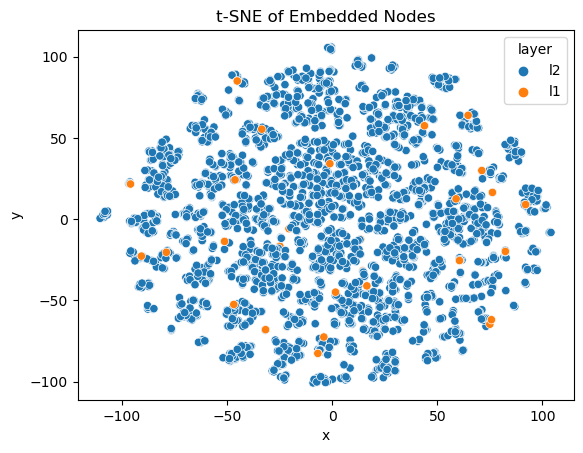

Generating walks (CPU: 7): 100%|██████████| 12/12 [01:03<00:00,  5.33s/it]


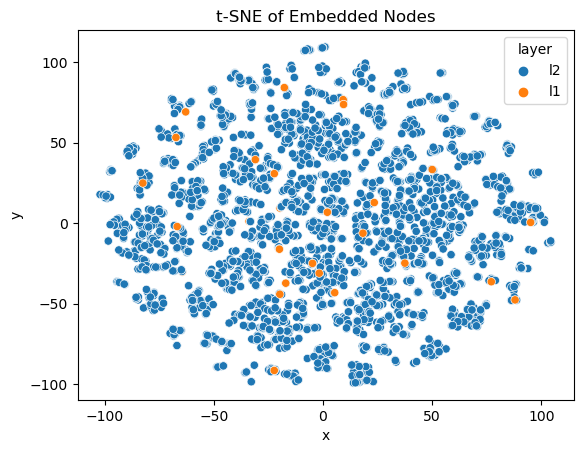

Generating walks (CPU: 4): 100%|██████████| 13/13 [01:37<00:00,  7.48s/it]


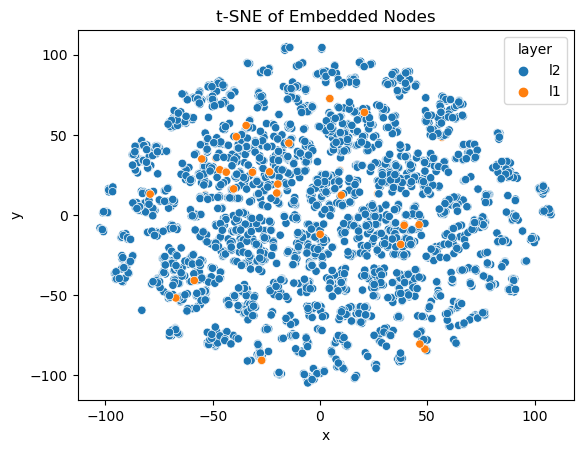

Generating walks (CPU: 8): 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]


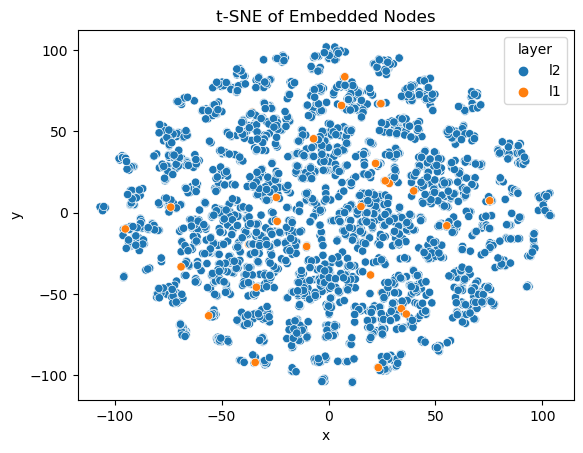

In [19]:
iterations = 2
dimensions = 10
n_classes = 20 #of GMM

graphs = [G,G2]
node_embeddings = np.zeros((len(graphs),iterations),dtype=object)

for i,g in enumerate(graphs):
    for j in range(iterations):
        node_embeddings[i,j] = g4p_lib.node2vec(g, dimensions=dimensions)
        g4p_lib.t_SNE(node_embeddings[i,j], n_components=2, plot=True, G=g)
    



In [20]:
#fit GNNs
GMMs = np.zeros((len(graphs),iterations),dtype=object)

for i,g in enumerate(graphs):
    for j in range(iterations):
        GMMs[i,j] = GaussianMixture(n_components=n_classes, covariance_type="full", 
                        max_iter=100, random_state=0).fit(node_embeddings[i,j])

<Axes: >

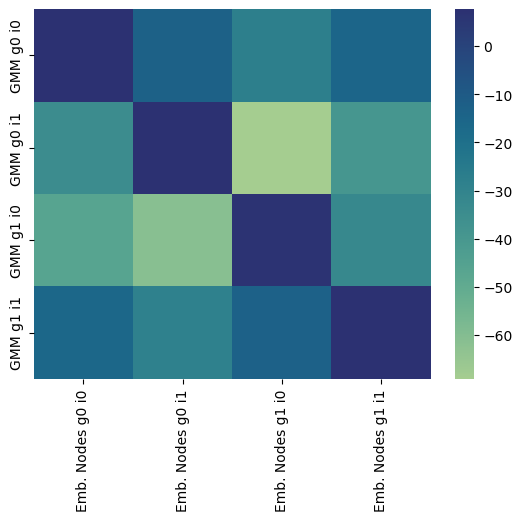

In [21]:
graph_iter_labels = [f"GMM g{g} i{i}" for g in range(len(graphs)) for i in range(iterations)]
embedding_iter_labels = [f"Emb. Nodes g{g} i{i}" for g in range(len(graphs)) for i in range(iterations)]

likelihoods = np.zeros((len(graphs)*iterations,len(graphs)*iterations))
for i,gmm in enumerate(GMMs.flatten()):
    for j,node_embedding in enumerate(node_embeddings.flatten()):
        likelihoods[i,j] = gmm.score(node_embedding)
        #print(f"GMM likelihood {gmm.score(node_embedding)}")

sns.heatmap(likelihoods,xticklabels=embedding_iter_labels, yticklabels=graph_iter_labels, cmap="crest" )

<Axes: >

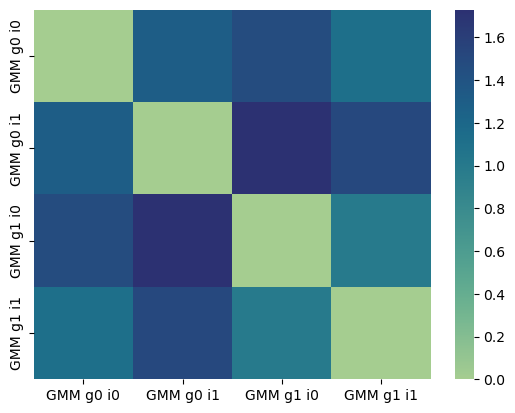

In [22]:
dist = np.zeros((len(graphs)*iterations,len(graphs)*iterations))
for i,gmm1 in enumerate(GMMs.flatten()):
    for j,gmm2 in enumerate(GMMs.flatten()):
        dist[i,j] = g4p_lib.GMM_wasserstein_dist(gmm1,gmm2)


sns.heatmap(dist,xticklabels=graph_iter_labels, yticklabels=graph_iter_labels,cmap="crest")

In [23]:
def plot_ellipses(gmm, pts=None, ax=None, title=None):
        if ax is None:
            fig =plt.figure()
            ax = fig.gca()
        n_classes = gmm.n_components
        colors = sns.color_palette("Set2",n_classes)
        for n, color in enumerate(colors):
            if gmm.covariance_type == "full":
                covariances = gmm.covariances_[n][:2, :2]
            elif gmm.covariance_type == "tied":
                covariances = gmm.covariances_[:2, :2]
            elif gmm.covariance_type == "diag":
                covariances = np.diag(gmm.covariances_[n][:2])
            elif gmm.covariance_type == "spherical":
                covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            ell = mpl.patches.Ellipse(
                gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
            )
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)
            ax.set_aspect("equal", "datalim")

        
        plt.xticks(())
        plt.yticks(())
        if pts is not None:
            plt.scatter(pts[:, 0],pts[:, 1])
        else:
            plt.show()

        if title is not None:
            plt.title(title)


def GMM_wasserstein_dist(GMM0,GMM1):
    K0,d = GMM0.means_.shape #currently only for d1 = d2
    K1, _ = GMM1.means_.shape

    pi0=GMM0.weights_
    mu0=GMM0.means_
    S0=GMM0.covariances_

    pi1=GMM1.weights_
    mu1=GMM1.means_
    S1=GMM1.covariances_

    wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
    return dist


def pairwise_GMM_wasserstein_dist(GMMs):
    dist = np.zeros((len(GMMs),len(GMMs)))
    for i,gmm1 in enumerate(GMMs):
        for j,gmm2 in enumerate(GMMs):
            dist[i,j] = GMM_wasserstein_dist(gmm1,gmm2)


    sns.heatmap(dist) #,xticklabels=graph_iter_labels, yticklabels=graph_iter_labels,cmap="crest")

#roation/reflection invariant OT
def inner_GMM__wasserstein_dist(GMM, pts):

    pi=GMM.weights_
    mu=GMM.means_
    S =GMM.covariances_
    
    #pts_of_comps = [[]] * len(S)

    comp_of_pts = GMM.predict(pts)
    #print(comp_of_pts)


    # Currently only alligns diagonals
    #Doesn't work for "full" gausians
    aligned_S = np.zeros(GMM.covariances_.shape)

    for component,(mu_,s) in enumerate(zip(mu,S)):   
        sorted_by_order = np.sort(s)

        #pca = PCA()
        #pca.fit(pts[comp_of_pts==component]-mu_)

        _, _, Vt = np.linalg.svd(pts[comp_of_pts==component]-mu_)

        aligned_S[component]  = np.cov(((pts[comp_of_pts==component]-mu_)@ Vt).T)
        #plt.figure(component+2)
        #v , w = np.linalg.eigh(s)
        #plt.scatter(v,w)

        #plt.scatter(s[:, 0],s[:, 1])
        #plt.scatter(((pts[comp_of_pts==component]-mu_)@ Vt )[:, 0],((pts[comp_of_pts==component]-mu_)@ Vt)[:, 1])

        #aligned_S[component]  = ((s-mu_) @ Vt ) +mu_

        #
        #s = s.reshape(-1, 1) 
        #print(s)

        #aligned_S[component] = pca.get_covariance() # sorted_by_order # np.squeeze(pca.fit_transform(s))

        #print(aligned_S[component])

    GMM.covariances_=aligned_S

    #plot_ellipses(GMM, pts)

    #compute pairwise wassersteins dists between gaussians
    dist = np.zeros((len(mu),len(mu)))
    for i,(m0,S0) in enumerate(zip(mu,aligned_S)):
        for j,(m1,S1) in enumerate(zip(mu,aligned_S)):
            #print(S0)
            dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1) 
    return dist
    


def random_GMM(n_components,title=None):
    x = np.random.randint(0, 50, 100)
    y = np.random.randint(0, 50, 100)
    pts = np.swapaxes(np.asarray([x,y]),axis1=0,axis2=1)   
    gmm = GaussianMixture(n_components=n_components, random_state=0).fit(pts)
    plot_ellipses(gmm,pts,title=title)

    return gmm, pts

In [24]:
#inner_dists = []
#labels = []

#for i in range(n):
    #GMMs.append(random_GMM(n_components,title=i))
    #inner_dists.append(inner_GMM__wasserstein_dist(*GMMs[-1]))
    #labels.append(i)

    #test by reflecting last GMM
    #swp_pts = GMMs[-1][1][:,[1,0]]
    #GMMs.append((GaussianMixture(n_components=n_components, random_state=0).fit(swp_pts), swp_pts))
    #plot_ellipses(*GMMs[-1],title=f"{i} flipped")
    #inner_dists.append(inner_GMM__wasserstein_dist(*GMMs[-1]))
    #labels.append(f"{i} flipped")

NameError: name 'n' is not defined

/tmp/ipykernel_3020093/65682586.py:118: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.676795e+00|0.000000e+00|0.000000e+00
    1|2.220446e-15|1.205521e+15|2.676795e+00
    2|5.326219e-16|3.168898e+00|1.687824e-15
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.750121e+00|0.000000e+00|0.000000e+00
    1|8.249893e-01|2.333524e+00|1.925132e+00
    2|5.386494e-01|5.315886e-01|2.863399e-01
    3|4.214817e-01|2.779899e-01|1.171677e-01
    4|4.063461e-01|3.724814e-02|1.513564e-02
    5|3.865289e-01|5.126972e-02|1.981723e-02
    6|3.850466e-01|3.849490e-03|1.482233e-03
    7|3.850466e-01|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.731890e+00|0.000000e+00|0.000000e+00
    1|8.958652e-01|2.049443e+00|1.836025e+00
    2|6.072662e-01|4.752430e-01|2.885990e-01
    3|4.414725e-01|3.755471e-01|1.657937e-01
    4|3.521009e-01|2.538236e-01|8.937

<Axes: >

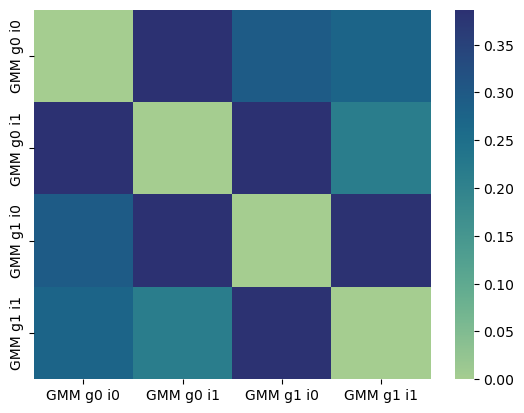

In [26]:
inner_dists = []

for i,gmm in enumerate(zip(GMMs.flatten(),np.asarray(node_embeddings).flatten())):
    inner_dists.append(inner_GMM__wasserstein_dist(*gmm))

dist = np.zeros((len(graphs)*iterations,len(graphs)*iterations))
for i,(dists1, gmm1) in enumerate(zip(inner_dists,GMMs.flatten())):
    for j,(dists2, gmm2) in enumerate(zip(inner_dists,GMMs.flatten())):
        w2, log = ot.gromov.gromov_wasserstein(
        C1=dists1, C2=dists2, p=gmm1.weights_, q=gmm2.weights_,loss_fun =  'square_loss', verbose=True, log=True)
        dist[i,j] = log['gw_dist']


sns.heatmap(dist,xticklabels=graph_iter_labels, yticklabels=graph_iter_labels,cmap="crest")

In [14]:
GMMs

[]